Global seed set to 2023


2018-02-20 23:00:00 2880 <Hour>
Training model: {'precision': '16-mixed', 'max_steps': 300, 'callbacks': [<pytorch_lightning.callbacks.progress.tqdm_progress.TQDMProgressBar object at 0x000001CC7676AA00>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x000001CC76853AF0>, <pytorch_lightning.callbacks.lr_monitor.LearningRateMonitor object at 0x000001CC767BACD0>], 'accelerator': 'gpu', 'devices': -1, 'enable_checkpointing': False, 'val_check_interval': 20, 'check_val_every_n_epoch': None}
16-mixed


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

16-mixed


Predicting: 0it [00:00, ?it/s]






Parsed results
PatchTST ETTh1 h=720
y_true.shape (n_series, n_windows, n_time_out):	 (7, 2161, 720)
y_hat.shape  (n_series, n_windows, n_time_out):	 (7, 2161, 720)
MSE:  0.38616627283395727
MAE:  0.429926024693078


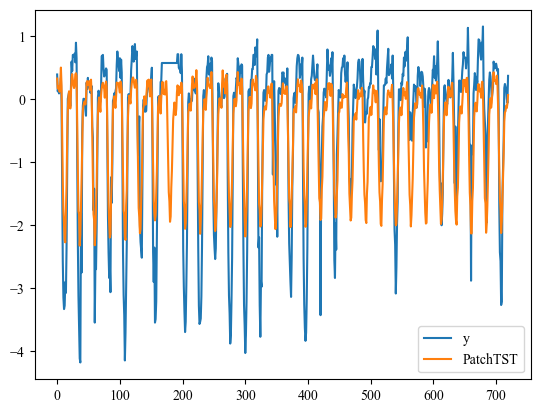

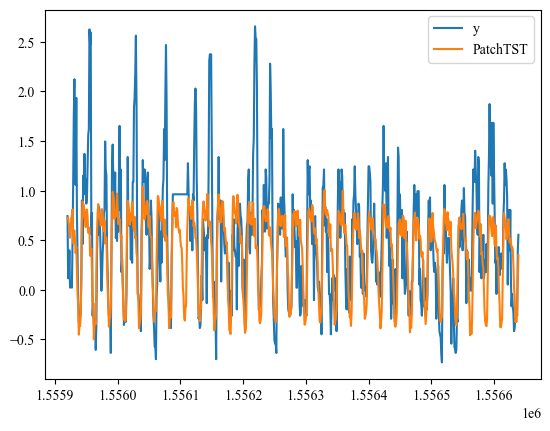

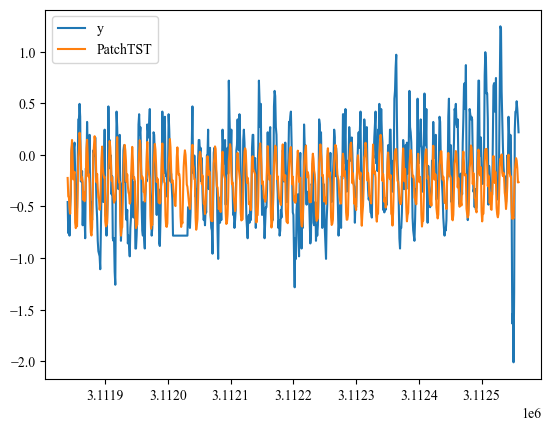

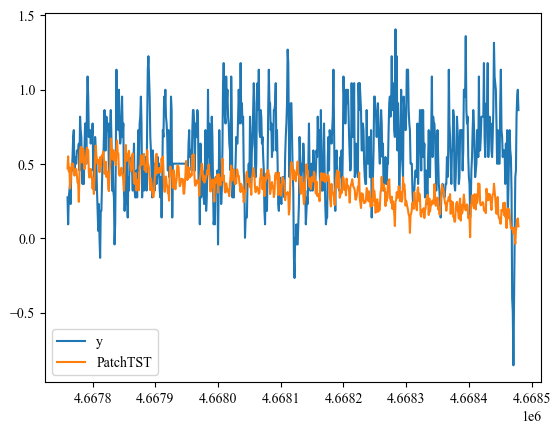

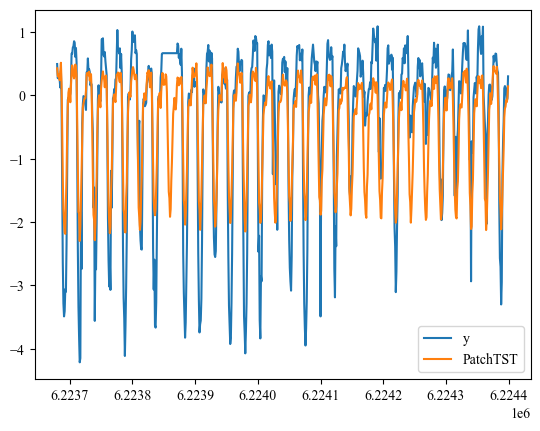

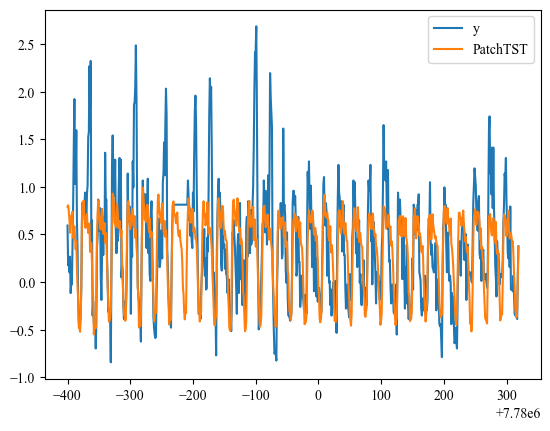

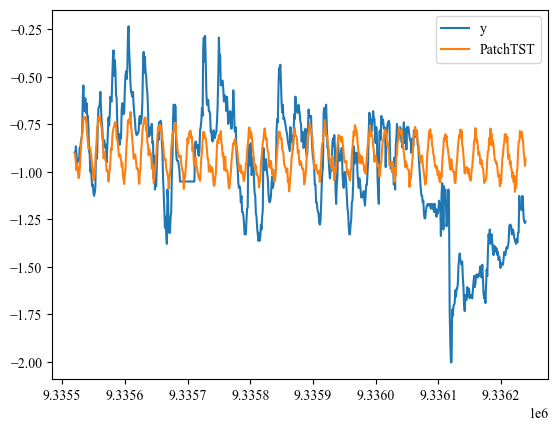

In [2]:
import pandas as pd
from neuralforecast.core import NeuralForecast
from neuralforecast.models.patchtst_with_dsp import PatchTST as PatchTSTWithDSP
from neuralforecast.losses.pytorch import MAE, MSE
from neuralforecast.losses.numpy import mae, mse
from datasetsforecast.long_horizon2 import LongHorizon2, LongHorizon2Info

input_size = 512
horizon = 720
dataset = "ETTh1"
epochs = 300

# read data：
Y_df = LongHorizon2.load(directory="./data/", group=dataset)
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
n_time = LongHorizon2Info[dataset].n_time
freq = LongHorizon2Info[dataset].freq
val_size = LongHorizon2Info[dataset].val_size
test_size = LongHorizon2Info[dataset].test_size
Y_df.drop(columns=["index"], inplace=True)

# init model
patchtst_dsp = PatchTSTWithDSP(
        h = horizon,
        input_size = input_size,
        encoder_layers = 3,
        n_heads = 4,
        hidden_size = 64,
        linear_hidden_size = 128,
        dropout = 0.2,
        fc_dropout = 0.2,
        head_dropout = 0.0,
        attn_dropout = 0.0,
        patch_len = 16,
        stride = 8,
        revin = True,
        revin_affine = False,
        revin_subtract_last = True,
        activation = "gelu",
        res_attention = True,
        batch_normalization = False,
        learn_pos_embed = True,
        loss=MAE(),
        valid_loss=MAE(),
        max_steps = epochs,
        learning_rate = 1e-4,
        num_lr_decays = -1,
        early_stop_patience_steps = 3,
        val_check_steps = 20,
        batch_size = 32,
        valid_batch_size = None,
        windows_batch_size = 1024, 
        inference_windows_batch_size = 1024,
        step_size = 2, 
        scaler_type = "identity",
        random_seed = 2023,
        num_workers_loader = 0, 
        stat_exog_list=None,
        hist_exog_list=None,
        futr_exog_list=None,
        exclude_insample_y=False,
        drop_last_loader = False,
)

# fit & test model
nf = NeuralForecast(models=[patchtst_dsp], freq=freq)
Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size,step_size=1, n_windows=None)
# calculate matrics
from neuralforecast.losses.numpy import mae, mse
y_true = Y_hat_df.y.values
y_hat = Y_hat_df["PatchTST"].values
n_series = len(Y_hat_df.unique_id.unique())
y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)
print("\n" * 4)
print("Parsed results")
print(f"PatchTST {dataset} h={horizon}")
print("y_true.shape (n_series, n_windows, n_time_out):\t", y_true.shape)
print("y_hat.shape  (n_series, n_windows, n_time_out):\t", y_hat.shape)
# print(' best validation hyperparameter:\t', nf.models[0].results.get_best_result().config)
print("MSE: ", mse(y_hat, y_true))
print("MAE: ", mae(y_hat, y_true))
# Y_hat_df.to_csv(f'./data/{dataset}_{horizon}_dsp.csv', index=False)
for unique_id in Y_hat_df.unique_id.unique():
  Y_hat_df[Y_hat_df['unique_id']==unique_id][['y','PatchTST']][0:720].plot()

